# Расчет близости текстов

# Настройка colab

Посмотрим что за видеокарта нам досталась. Если никакой - запускать берт бессмыслено, считаться будет вечность. Выберете GPU.

In [ ]:
!nvidia-smi

Wed Feb  3 08:07:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Устанавливаем библиотеку [Sentence Transformers](https://github.com/UKPLab/sentence-transformers)

In [ ]:
!pip install -U sentence-transformers

     |████████████████████████████████| 71kB 3.5MB/s 
     |████████████████████████████████| 1.8MB 7.1MB/s 
     |████████████████████████████████| 1.2MB 46.3MB/s 
     |████████████████████████████████| 2.9MB 55.8MB/s 
     |████████████████████████████████| 890kB 52.3MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.4.1.2-cp36-none-any.whl size=103068 sha256=ae25e8802c7572df3da8e1349a463a5a9b9224f64b2c89084362440c6e91a47b
  Stored in directory: /root/.cache/pip/wheels/3d/33/d1/5703dd56199c09d4a1b41e0c07fb4e7765a84d787cbdc48ac3
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=8013b144044970fea1df480c4b6de1267192bc326ba8d0de35630f3f22f2e3aa
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Библиотеки

In [ ]:
import json
import os
from google.colab import drive
from tqdm import tqdm
import pickle
from collections import Counter

import pandas as pd

import numpy as np
import scipy
from scipy import spatial

from sentence_transformers import SentenceTransformer

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Предобученная модель

Скачиваем предобученную модель

In [ ]:

model = SentenceTransformer('bert-base-nli-mean-tokens') #эта быстрее
#model = SentenceTransformer('bert-large-nli-mean-tokens') #эта точнее


100%|██████████| 405M/405M [00:43<00:00, 9.31MB/s]


# Загрузка файлов с google colab

Посмотрим в той ли мы папке. Путь на вашем гуглодиске может быть другим так что проверьте что тут лежат файлы 'comments_2015_01.txt',... и только они, только нужные файлы

In [ ]:
os.listdir("/content/drive/My Drive/PoliticalDiscussion")[:5]

['comments_2015_01.txt',
 'comments_2015_02.txt',
 'comments_2015_03.txt',
 'comments_2015_04.txt',
 'comments_2015_05.txt']

Собираем все файлы в один, сразу выкидывая удаленных авторов и комментраии

In [ ]:
%%time
comments_list = list()
users = list()

for my_file in tqdm(os.listdir("/content/drive/My Drive/PoliticalDiscussion"), position=0, leave=True):
  with open("/content/drive/My Drive/PoliticalDiscussion/" + my_file) as json_file:
        for json_obj in json_file:
          comment_dict = json.loads(json_obj)
          if comment_dict["author"] != "[deleted]" and comment_dict["body"] != "[deleted]":
            comments_list.append(comment_dict)
            users.append(comment_dict["author"])
del(comment_dict)

100%|██████████| 36/36 [01:16<00:00,  2.12s/it]

CPU times: user 18.7 s, sys: 2.33 s, total: 21 s
Wall time: 1min 16s


Посмотрим на объем загруженных данных и на сами данные



In [ ]:
len(comments_list)

2892098

In [ ]:
comments_list[:2]

[{'author': 'Jewbilant',
  'body': "I don't know what sort of universe you live in, but I know of nobody that has made that argument. But comparisons of Israel to Nazi Germany, attempts to designate Zionism as Racism, and the application of different different standards for Israel &amp; the rest of the world is all too common. The largest international body in the world is guilty of this. You can criticize Israel and nobody (well, maybe some guy on the Internet but nobody prominent) thinks that's antisemitic. ",
  'comment_id': 't1_cnas9ff',
  'created_utc': 1420070428,
  'downs': 0,
  'parent_id': 't1_cnar50k',
  'score': 9,
  'ups': 9},
 {'author': 'Einsteinsmooostache',
  'body': "It just occurred to me that perhaps I didn't explain my reason for wanting it very well. This may fall on deaf ears now, and maybe rightfully so, but my interest was in allowing someone interested to explore more in depth, with the added benefit of fact checking. \n\nI just realized this after looking a th

Отбросим тех, кто написал за время наблюдений меньше чем N постов

In [ ]:
# Remove elements of  
# list that repeated less than k times 
  
def removeElements(lst, k): 
    counted = Counter(lst) 
    return [el for el in lst if counted[el] >= k] 

In [ ]:
users_filtered = removeElements(users, 100)
len(users_filtered)

2246197

Посмотрим сколько таких людей в нашей выборке

In [ ]:
unique_users = set(users_filtered)
len(unique_users)

5014

Удалим комменты тех, кто не из вышеуказанных

In [ ]:
comments_list_clean = list()
with tqdm(total=len(users_filtered), position=0, leave=True) as pbar:
  for row in comments_list:
    if row["author"] in unique_users:
      comments_list_clean.append(row)
      pbar.update(1)    

100%|██████████| 2246197/2246197 [00:02<00:00, 1092550.08it/s]


Наконец, давайте посмотрим на данные

In [ ]:
comments_df = pd.DataFrame(comments_list_clean)
comments_df.tail()

comment_id  created_utc            author  ... score ups  downs
2246192  t1_ds0hqje   1514758355     cuddlefishcat  ...     1 NaN    NaN
2246193  t1_ds0iilq   1514759290  Whatyoushouldask  ...     0 NaN    NaN
2246194  t1_ds0knuc   1514761858     karmapuhlease  ...     1 NaN    NaN
2246195  t1_ds0mavn   1514763855    PerfectSociety  ...     1 NaN    NaN
2246196  t1_ds0mkdq   1514764179   ScoobiusMaximus  ...     5 NaN    NaN

[5 rows x 8 columns]

Освободим память от уже ненужных но жирных объектов

In [ ]:
del(comments_list)
del(comments_list_clean)

# Embeddings для комментов


Векторизуем комменты

Запустим расчет векторов. Achtung: за полтора года для тех кто написал больше 100 комментов считалось 1h 51min 52s на bert-base и 8h 40min на bert-large. Заварите побольше чая или вообще запустите на ночь и идите спать)

In [ ]:
%%time
comments_df = comments_df.sample(20000)  # пробуем сначала на маленькой выборке
comment_embedding = model.encode(comments_df['body'].to_list(), device='cuda')
comments_df['embedding'] = list(comment_embedding)

CPU times: user 37.5 s, sys: 15.4 s, total: 52.9 s
Wall time: 47.6 s


In [ ]:
comments_df.head()

comment_id  ...                                          embedding
1565295  t1_d7340m3  ...  [-0.06422905, 0.026463317, 0.59619236, 0.06843...
2006673  t1_ddinm30  ...  [-0.21077484, 0.6779574, -0.76896054, 0.231262...
1544434  t1_d6rcxm9  ...  [0.24558182, 1.1844555, -0.49387673, -0.148174...
69498    t1_cqsbctz  ...  [-0.29384786, 0.07195934, -0.5486883, 0.185634...
485614   t1_czofqne  ...  [-0.3639773, 0.30408216, 1.1062942, 0.5308161,...

[5 rows x 9 columns]

Сохраним полученную таблицу данных

In [ ]:
'''
with open('comments_df.pickle', 'wb') as f:
  pickle.dump(comments_df, f)
  '''

"\nwith open('comments_df_clear_more100_2015-2017_part5of4.pickle', 'wb') as f:\n  pickle.dump(comments_df_part5of4, f)\n  "

In [ ]:

with open('/content/drive/My Drive/weights/comments_df.pickle', 'wb') as f:
  pickle.dump(comments_df, f)

# Подготовка маяка

In [ ]:
%%time
Trump_reference_texts = (
'This is why we need Trump to win. With the USA as  trendsetter, we can purge the traitors from office!',
'Bitcoin will soon be called Trump Coin it’ll be so great!',
'Daddy Trump is gonna make Daycare Great Again!',
'they was hoping trump would give them a boost in california. the tears are delicious',
'Flawless Centipede... Submit to @Twinksfortrump and follow @Gay4Trump',
'But if Bernie debates trump and a meteorite hit Hillary then sanders will win! Remember guys phone bank, donate, match me',
'edited because i was a tool, and edited to say LostTrumpSupporter is AWESOME!',
'my best tips are almost always from trump supporters. i guess when youre employed you can afford to be a generous person',
'And it will work, until Trump makes America so fucking awesome nobody would want to change it.',
'Poseidon is doing his best to protect the West.  Thank you based Poseidon.',
'Trump/Poseidon 2016',
'Probably made a script to respond to all of Trump’s newest tweets with pre-written tweets. He’s an impressive centipede!',
'Donald Trump is best',
'Trump has a diet for this country and trust me it’s gonna be nutritious and delicious',
'Mr. Trump all we do is win i need a break!',
'Babes are awesome so are Trump fellas.',
'That’s a cuck way of looking at it, Trump **WILL WIN 50+DC**!',
'Trump Tower has the best taco bowls.',
"immigrants are bad",
"Immigrants will take American jobs, lower our wages, and especially hurt the poor",
"Immigrants abuse the welfare state",
"Immigrants increase the budget deficit and government debt",
"Immigrants increase economic inequality",
"Today’s immigrants don’t assimilate like immigrants from previous waves did",
"Immigrants are a major source of crime",
"Immigrants pose a unique risk today because of terrorism",
"It’s easy to immigrate to America and we’re the most open country in the world",
"Amnesty or a failure to enforce our immigration laws will destroy the Rule of Law in the United States",
"By not exercising control over borders through actively blocking immigrants, the users of this argument warn, the United States government will surrender a vital component of its national sovereignty",
"Immigrants won’t vote for the Republican Party",
"Immigrants bring with them their bad cultures, ideas, or other factors that will undermine and destroy our economic and political institutions.  The resultant weakening in economic growth means that immigrants will destroy more wealth than they will create over the long run",
"The brain drain of smart immigrants to the United State impoverished other countries",
"Immigrants will increase crowding, harm the environment",
'Hey man im in north jersey as well. I wear my MAGA gear with pride and drive around with my trump bumper sticker. Im in morris county. Dont let the libs win. Trump 2016!!!',
'I’m not asking for a VP that is lockstep with Trump. But accepting a VP who was a prime mover in the passage of one of the greatest frauds foisted upon the US ever is NOT acceptable as VP. VP is a heartbeat from POTUS',
'The official Donald Trump MAGA cap is the one the Don himself wears. It’s the one I bought, and let me tell you folks, it is the best hat around, the best, believe me.'
)
# reference_texts = ("immigrants are bad",
#                    "Immigrants will take American jobs, lower our wages, and especially hurt the poor",
#                    "Immigrants abuse the welfare state",
#                    "Immigrants increase the budget deficit and government debt",
#                    "Immigrants increase economic inequality",
#                    "Today’s immigrants don’t assimilate like immigrants from previous waves did",
#                    "Immigrants are a major source of crime",
#                    "Immigrants pose a unique risk today because of terrorism",
#                    "It’s easy to immigrate to America and we’re the most open country in the world",
#                    "Amnesty or a failure to enforce our immigration laws will destroy the Rule of Law in the United States",
#                    "By not exercising control over borders through actively blocking immigrants, the users of this argument warn, the United States government will surrender a vital component of its national sovereignty",
#                    "Immigrants won’t vote for the Republican Party",
#                    "Immigrants bring with them their bad cultures, ideas, or other factors that will undermine and destroy our economic and political institutions.  The resultant weakening in economic growth means that immigrants will destroy more wealth than they will create over the long run",
#                    "The brain drain of smart immigrants to the United State impoverished other countries",
#                    "Immigrants will increase crowding, harm the environment")

# reference_texts = ("my cat is nice"
#                   )
    

Trump_ref_vecs = model.encode(reference_texts)

CPU times: user 69.7 ms, sys: 11 ms, total: 80.7 ms
Wall time: 76.2 ms


# Sanity Check

In [ ]:
text_texts_simple = (
    # "Westgate-on-Sea is a seaside town and civil parish in northeast Kent, England, with a population of 6,996 at the 2011 Census. It is within the Thanet local government district and borders the larger seaside resort of Margate. Its two sandy beaches have attracted tourists since the town's development in the 1860s from a small farming community. The local St Mildred's Bay was the site of a Royal Naval Air Service seaplane base, which defended the Thames Estuary coastal towns during World War I.",
    # "Bean is one of the silliest dogs I have ever met. She is always managing to get in trouble somehow or at the very least getting into some kind of mischief. She makes me laugh when she gets excited and she makes me laugh when she falls asleep in the strangest positions. It feels like no matter what Bean is doing, I always manage to laugh for some reason.",
    # "It’s a lot of work to own a dog, but I’ve also never been in greater shape in my life. Bean reminds me to get up, get outside, and exercise through our walks. What’s great is that Bean also exercises my mind as well! Training her can be hard work sometimes and I’m always trying to come up with new ways to handle and entertain her.",
    # "Most dogs are dirty and smelly. You can literally smell when someone owns a furry creature. Maintenance of their hygiene requires time and money that I do not have. On top of that, dogs never leave you alone. Maybe it’s my inner introvert talking, but I don’t want to come home to a dog sticking its nose in my business and begging for attention. I want peace, quiet and solitude.",
    # "For myself, I don’t think there’s any question that Donald Trump is a very imperfect vessel and that everyone wishes he did many things differently.  And I think Trump’s election was just as much, if not more, about Barak Obama’s left-wing overreach and Hilary Clinton’s spectacular flaws, as it was about Trump’s skill in articulating the dramatic change that resonated with middle America.  I am thankful that his campaign found a path to victory, and I think, policywise, he is on his way to becoming one of our greatest presidents.",
    "Trump's margin of victory was extremely narrow. If that suggests anything at all, it suggests that a single major factor breaking Clinton's way instead of Trump's would have flipped the election. Russian interference was a major factor. It wasn't the only major factor, and Clinton still could have won, but she also *would* have won had Putin not interfered.",
    "Trump bad!",
    "Trump is the best!",
    "Hillary is the best!",
    "immigrants are bad"

)

In [ ]:
text_texts_simple_vecs = model.encode(text_texts_simple)

In [ ]:
text_texts_simple_labels = list()
for i in text_texts_simple:
  text_texts_simple_labels.append(i[:50])
  print(text_texts_simple_labels)
  print("\n")

["Trump's margin of victory was extremely narrow. If"]


["Trump's margin of victory was extremely narrow. If", 'Trump bad!']


["Trump's margin of victory was extremely narrow. If", 'Trump bad!', 'Trump is the best!']


["Trump's margin of victory was extremely narrow. If", 'Trump bad!', 'Trump is the best!', 'Hillary is the best!']


["Trump's margin of victory was extremely narrow. If", 'Trump bad!', 'Trump is the best!', 'Hillary is the best!', 'immigrants are bad']




In [ ]:
text_texts_simple_vecs

array([[-1.0945894 , -0.01131588, -0.96482974, ..., -0.20393807,
        -0.43766013,  0.64302   ],
       [ 0.0122356 ,  0.5221699 ,  1.1257793 , ..., -0.61463636,
         0.14970091, -0.21863814],
       [-0.6463706 ,  0.17489253,  1.1177332 , ..., -0.14349464,
         0.13524039, -0.06210864],
       [-0.57032   ,  0.38709858,  1.2921921 , ..., -0.08941441,
         0.08369451,  0.4686629 ],
       [-0.02385484,  0.65895003,  0.30720386, ..., -0.63859046,
        -0.32460734, -0.07390022]], dtype=float32)

In [ ]:
cos_sim = cosine_similarity(text_texts_simple_vecs)

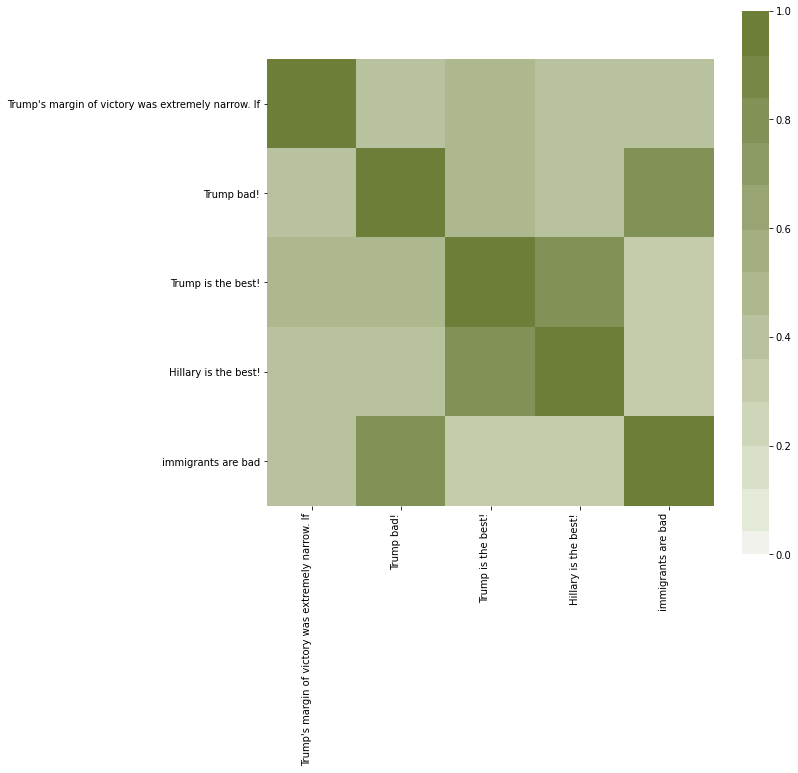

In [ ]:
plt.subplots(figsize=(10,10))
ax = sns.heatmap(
    cos_sim, 
    vmin=0, vmax=1, center=0,
    cmap=sns.diverging_palette(10, 100, n=25),
    square=True,
    
)
ax.set_xticklabels(
    text_texts_simple_labels,
    rotation=90,
    horizontalalignment='right'
);

ax.set_yticklabels(
    text_texts_simple_labels,
    rotation=00,
    horizontalalignment='right'
);

# Анализ данных

загружаем ранее сохраненную таблицу с embeddings

In [ ]:
'''
%%time
comments_df = pd.DataFrame()
tmp = pd.DataFrame()

for my_file in tqdm(os.listdir("/content/drive/My Drive/weights/"), position=0, leave=True):
  print(my_file)
  with open("/content/drive/My Drive/weights/" + my_file, mode='rb') as pandas_file:
    tmp = pickle.load(pandas_file)
    comments_df = comments_df.append(tmp)
del(tmp)
'''

  0%|          | 0/2 [00:00<?, ?it/s]

comments_df_part5of4.pickle


 50%|█████     | 1/2 [00:10<00:10, 10.57s/it]

comments_df_clear_more100_2015-2017_part5of4.pickle


100%|██████████| 2/2 [00:26<00:00, 13.39s/it]

CPU times: user 9.02 s, sys: 1.87 s, total: 10.9 s
Wall time: 26.8 s


In [ ]:
print('Размер датасета:', comments_df.shape)
comments_df.tail()

Размер датасета: (20000, 10)


comment_id  ...  similarity
19521    t1_coit52b  ...    0.723721
519092   t1_czwq3kz  ...    0.666718
293859   t1_cwvl0mi  ...    0.734217
1601905  t1_d7jyfyh  ...    0.601725
2158806  t1_dkrbhyl  ...    0.608017

[5 rows x 10 columns]

посчитаем косинусные расстояния и добавим в таблицу



In [ ]:
scores = list()
for vec in tqdm(comments_df['embedding'], position=0, leave=True):
  tmp = list()
  for ref_vec in ref_vecs:    
    tmp.append(1 - spatial.distance.cosine(vec, ref_vec))
  
  scores.append(max(tmp))

100%|██████████| 20000/20000 [00:38<00:00, 518.48it/s]


In [ ]:
comments_df["similarity"] = scores
comments_df.head()

comment_id  ...  similarity
1565295  t1_d7340m3  ...    0.619657
2006673  t1_ddinm30  ...    0.748135
1544434  t1_d6rcxm9  ...    0.665011
69498    t1_cqsbctz  ...    0.640206
485614   t1_czofqne  ...    0.463184

[5 rows x 10 columns]

In [ ]:
del(tmp)
del(scores)

In [ ]:
#comments_df.author.unique()

In [ ]:

def moving_average(a, n=15):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


In [ ]:
%%time
comments_df_sorted = comments_df.sort_values(by=['author'],ignore_index=True,kind='mergesort')

CPU times: user 49.9 ms, sys: 0 ns, total: 49.9 ms
Wall time: 55.3 ms


In [ ]:
comments_df_sorted = comments_df_sorted.drop(['ups', 'downs'], axis=1)
comments_df_sorted = comments_df_sorted.dropna()
comments_df_sorted.head()

comment_id  ...  similarity
0  t1_d4dv9v8  ...    0.630984
1  t1_d3mwevx  ...    0.708592
2  t1_d371i10  ...    0.671032
3  t1_d2xegow  ...    0.722374
4  t1_d034k72  ...    0.671898

[5 rows x 8 columns]

Изобразим больше людей на одном графике. Считается безумно долго, you are welcom to optimize this shit. Если нажмете на "стоп" то нарисуется столько, сколько успело посчитаться was 5%|▍         | 153/3391 [4:56:18<106:34:08, 118.48s/it] UPD Ототимизировал это говно!! Теперь на иттерацию 0.02 секунды тратится!

100%|██████████| 4268/4268 [00:08<00:00, 475.45it/s]


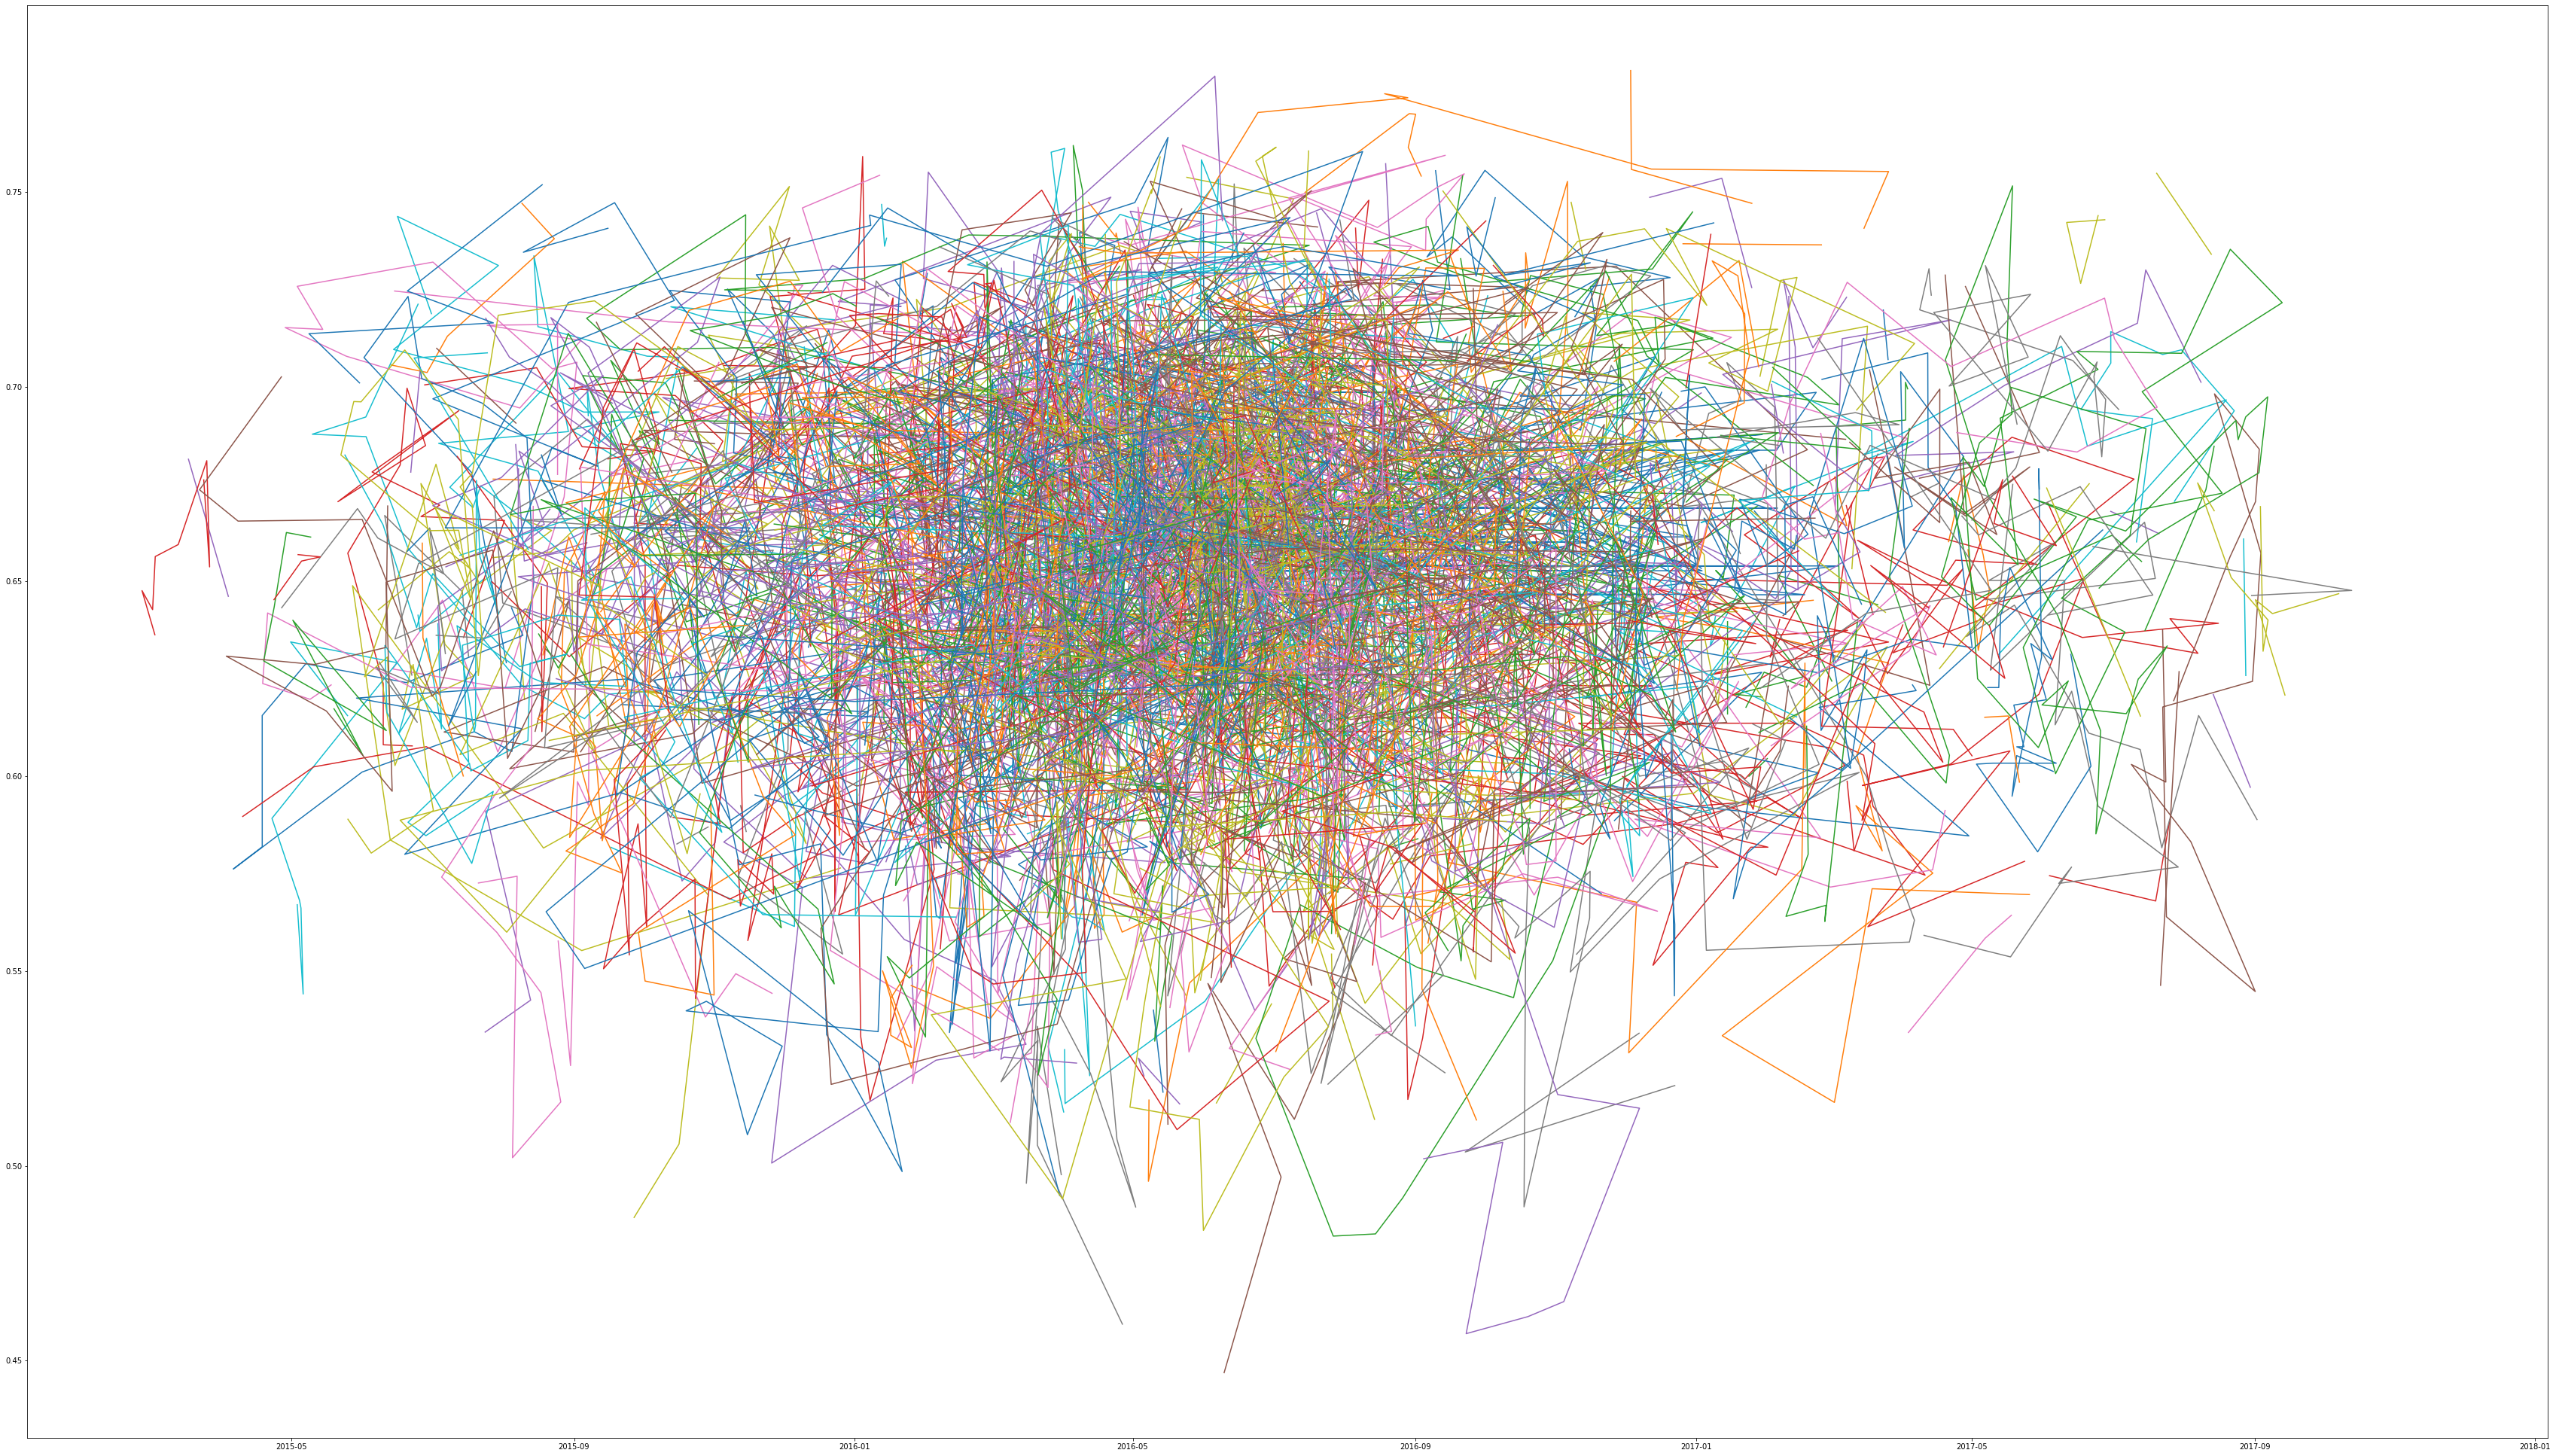

In [ ]:
fig1 = plt.figure(figsize=(60, 35))
from matplotlib import dates
import datetime

occurrences = dict(comments_df_sorted.author.value_counts())

ax1 = fig1.add_subplot()
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])

Start_from = 0

for user in tqdm(sorted(occurrences.keys()), position=0, leave=True):
  coordinats = list()
  timestep = list()
  for index, row in comments_df_sorted.iloc[Start_from: Start_from+occurrences[user]].iterrows():
    coordinats.append(row.similarity)
    timestep.append(row.created_utc)
  
  Start_from += occurrences[user]

  s = moving_average(timestep, n=5) #Плохо среднее по времени считать
  dts = list(map(datetime.datetime.fromtimestamp, s))
  plt.plot(dts, moving_average(coordinats, n=5))


plt.show()

# Кластеризация

scatterplot

In [ ]:
def plot_2d_representation_of_words(
    word_vectors, 
    flip_x_axis = False,
    flip_y_axis = False,
    label_x_axis = "x",
    label_y_axis = "y", 
    label_label = "city"):
    
    pca = PCA(n_components = 2)
    
    word_plus_coordinates = pd.DataFrame(word_vectors)
        
    coordinates_2d = pca.fit_transform(word_plus_coordinates.iloc[:,:])
    coordinates_2d = pd.DataFrame(coordinates_2d, columns=[label_x_axis, label_y_axis])
 
    if flip_x_axis:
        coordinates_2d[label_x_axis] = \
        coordinates_2d[label_x_axis] * (-1)
    if flip_y_axis:
        coordinates_2d[label_y_axis] = \
        coordinates_2d[label_y_axis] * (-1)
            
    plt.figure(figsize = (15,10))
    p1=sns.scatterplot(data=coordinates_2d, x=label_x_axis, y=label_y_axis)
    
    x = coordinates_2d[label_x_axis]
    y = coordinates_2d[label_y_axis]
    
    plt.show()

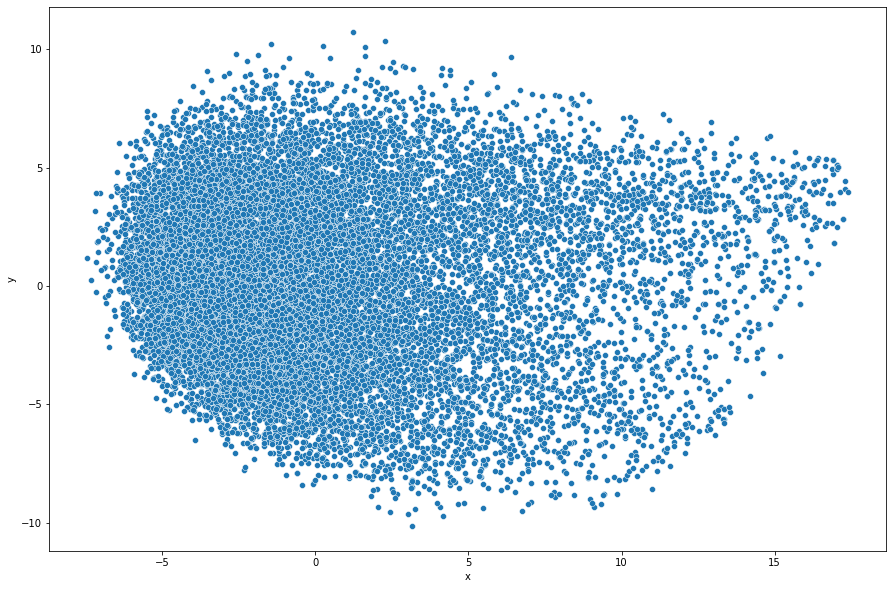

In [ ]:
plot_2d_representation_of_words(list(comments_df['embedding']))

In [ ]:
#users


Будет круто так же посчитать кластеризацию, посмотреть на распределения данных и так далее

In [ ]:
#place for your awesome research

# Многоклассовая классификация для оценки комментария